# Задача 9. Эксперименты: Статика vs. Динамика

Цель эксперимента: сравнить реализации трех алгоритмов для SSSP при условии, что графы меняются.
Алгоритмы:
- Дейкстры
- Динамический вариант алгоритма Дейкстры
- Беллмана-Форда при помощи матричных умножений

Алгоритмы прогоняются на графах размеров 100, 1000, 5000, 10000, 25000, 50000, 100000. При этом для каждого графа меняется процент изменяющихся ребер: 10%, 20%, 30%, 40%, 50% от общего числа ребер в графе. Также меняется способ обновления: инкрементальный (ребра только добавляются), декрементальный (ребра только удаляются), смешанный (ребра могут добавляться и удаляться)


In [5]:
import random
import time

from project import dyn_sp
from project import shortest_paths as sp
import networkx as nx

## Оборудование

CPU:   Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz

Cores: 4

RAM:   16GiB

## Генерация графов

Для генерации графов были использованы генераторы [karate_club_graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.social.karate_club_graph.html#networkx.generators.social.karate_club_graph) (из области социальных графов) и [gaussian_random_partition_graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.gaussian_random_partition_graph.html#networkx.generators.community.gaussian_random_partition_graph) (для поиска сообществ). Гауссовский генератор был выбран, так как среди прочих он позволяет задавать графы, в которых при удалении набора ребер количество достижимых вершин не увеличивается. Например, в [caveman_graph'е](https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.caveman_graph.html#networkx.generators.community.caveman_graph) при удалении ребер из цикла будет образовываться все больше компонент связности, что повлияет на вершинную достижимость.

In [6]:
%%time

graphs = {
    '100': nx.karate_club_graph().to_directed(),
    '1000': nx.gaussian_random_partition_graph(1000, 10, 3, 0.05, 0.01, True, seed=123),
    '5000': nx.gaussian_random_partition_graph(5000, 50, 3, 0.01, 0.005, True, seed=123),
    '10000': nx.gaussian_random_partition_graph(10000, 100, 3, 0.01, 0.005, True, seed=123),
    '25000': nx.gaussian_random_partition_graph(25000, 250, 3, 0.001, 0.0005, True, seed=123),
    '50000': nx.gaussian_random_partition_graph(50000, 500, 3, 0.0005, 0.0005, True, seed=123),
    '100000': nx.gaussian_random_partition_graph(100000, 1000, 3, 0.0001, 0.0001, True, seed=123)
}

print('Graph sizes:')
for _, graph in graphs.items():
    print(f'{len(graph)} vertices, {len(graph.edges)} edges')

Graph sizes:
34 vertices, 156 edges
1000 vertices, 10488 edges
5000 vertices, 126263 edges
10000 vertices, 504688 edges
25000 vertices, 316361 edges
50000 vertices, 1250131 edges
100000 vertices, 999949 edges
CPU times: user 1min 43s, sys: 304 ms, total: 1min 44s
Wall time: 1min 44s


## Измерения

In [7]:
def sssp_with_time(src, graph):
    graph = sp.nx_graph_to_matrix(graph)
    start = time.time()
    sp.sssp(graph, src)
    end = time.time()

    return end - start

def dijkstra_with_time(src, graph):
    start = time.time()
    dyn_sp.dijkstra(src, graph)
    end = time.time()

    return end - start

In [8]:
changed_edges_num = [0.1, 0.2, 0.3, 0.4, 0.5]
results = {
    'inc': {},
    'dec': {},
    'full': {}
}

for mod_size in changed_edges_num:
    results['inc'][mod_size] = {
        'sssp': [],
        'dyn_sssp': [],
        'dijkstra': []
    }
    results['dec'][mod_size] = {
        'sssp': [],
        'dyn_sssp': [],
        'dijkstra': []
    }
    results['full'][mod_size] = {
        'sssp': [],
        'dyn_sssp': [],
        'dijkstra': []
    }

    for g in graphs.values():
        src = random.choice(list(g.nodes))
        edges_to_modify = random.choices(list(g.edges), k=int(len(g) * mod_size))
        edges_to_keep = g.edges - edges_to_modify

        #=============increment=============
        new_g = nx.DiGraph()
        new_g.add_nodes_from(g.nodes)
        new_g.add_edge(edges_to_modify)

        t = sssp_with_time(src, new_g)
        results['inc'][mod_size]['sssp'].append(t)

        t = dijkstra_with_time(src, new_g)
        results['inc'][mod_size]['dijkstra'].append(t)

        new_g = nx.DiGraph()
        new_g.add_nodes_from(g.nodes)

        algo = dyn_sp.DynSssp(src, new_g)
        for u, v in edges_to_modify:
            algo.add_edge(u, v)

        start = time.time()
        algo.get_dists()
        end = time.time()

        results['inc'][mod_size]['dyn_sssp'].append(end - start)

        #=============decrement=============
        new_g = nx.DiGraph()
        new_g.add_nodes_from(g.nodes)
        new_g.add_edges_from(edges_to_keep)

        t = sssp_with_time(src, new_g)
        results['dec'][mod_size]['sssp'].append(t)

        t = dijkstra_with_time(src, new_g)
        results['dec'][mod_size]['dijkstra'].append(t)

        new_g = g.copy()

        algo = dyn_sp.DynSssp(src, new_g)
        for u, v in edges_to_modify:
            algo.remove_edge(u, v)

        start = time.time()
        algo.get_dists()
        end = time.time()
        results['dec'][mod_size]['dyn_sssp'].append(end - start)

        #=============full=============
        edges_num = len(edges_to_modify)//2
        add_edges = random.sample(list(edges_to_modify), edges_num)
        remove_edges = list(set(edges_to_modify) - set(add_edges))

        new_g = nx.DiGraph()
        new_g.add_nodes_from(g.nodes)
        new_g.add_edges_from(g.edges - remove_edges)

        t = sssp_with_time(src, new_g)
        results['full'][mod_size]['sssp'].append(t)

        t = dijkstra_with_time(src, new_g)
        results['full'][mod_size]['dijkstra'].append(t)

        new_g = nx.DiGraph()
        new_g.add_nodes_from(g.nodes)
        new_g.add_edges_from(g.edges - add_edges)

        algo = dyn_sp.DynSssp(src, new_g)
        for u, v in zip(add_edges, remove_edges):
            algo.add_edge(*u)
            algo.remove_edge(*v)

        start = time.time()
        algo.get_dists()
        end = time.time()
        results['full'][mod_size]['dyn_sssp'].append(end - start)



## Результаты

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
sizes = [100, 1000, 5000, 10000, 25000, 50000, 100000]
barWidth = 0.09

for t in ['inc', 'dec', 'full']:
    res = results[t]

    for edges_ration in changed_edges_num:
        br1 = np.arange(len(res[edges_ration]['sssp']))
        br2 = [x + barWidth for x in br1]
        br3 = [x + barWidth for x in br2]

        plt.bar(br1, res[edges_ration]['sssp'], color='r', width=barWidth, label='sssp')
        plt.bar(br2, res[edges_ration]['dijkstra'], color='b', width=barWidth, label='dijkstra')
        plt.bar(br3, res[edges_ration]['dyn_sssp'], color='g', width=barWidth, label='dyn_sssp')
        if edges_ration == changed_edges_num[0]:
            plt.ylabel('Time')

        plt.grid(axis='y')
        plt.xlabel('Graph size')
        plt.xticks([r + barWidth for r in range(len(res[edges_ration]['sssp']))], sizes)

        plt.title(f"Modification ratio: {edges_ration}")
        if edges_ration == changed_edges_num[0]:
            plt.legend()

        plt.yscale('log')

        plt.savefig(f'{t}_{edges_ration}.png')
        plt.close()
        plt.clf()




<Figure size 640x480 with 0 Axes>

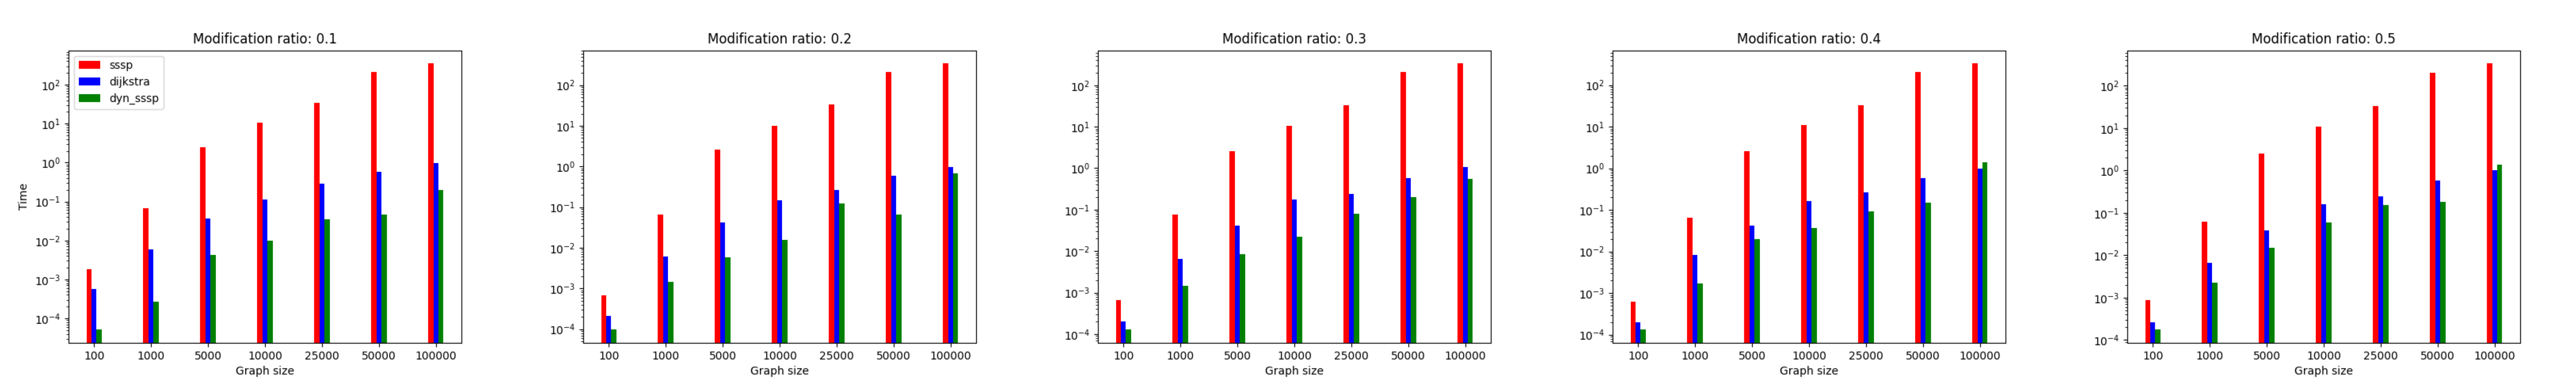

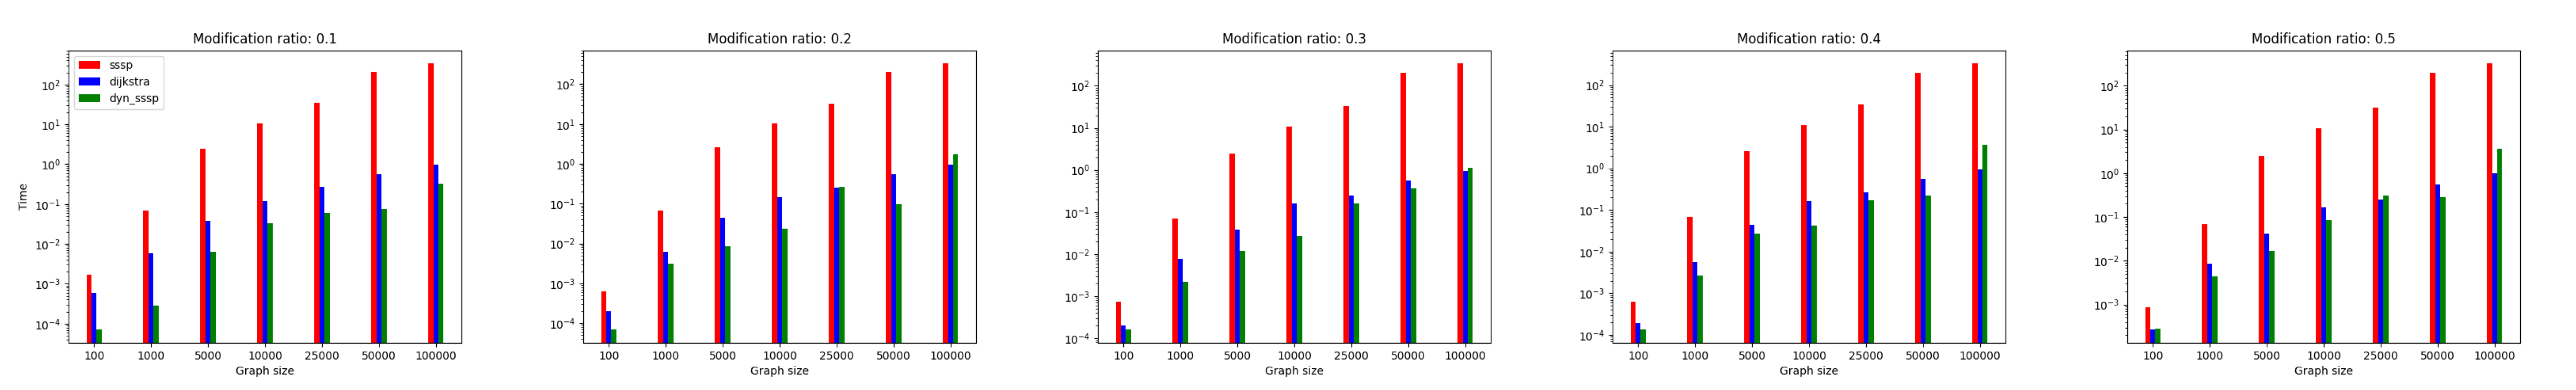

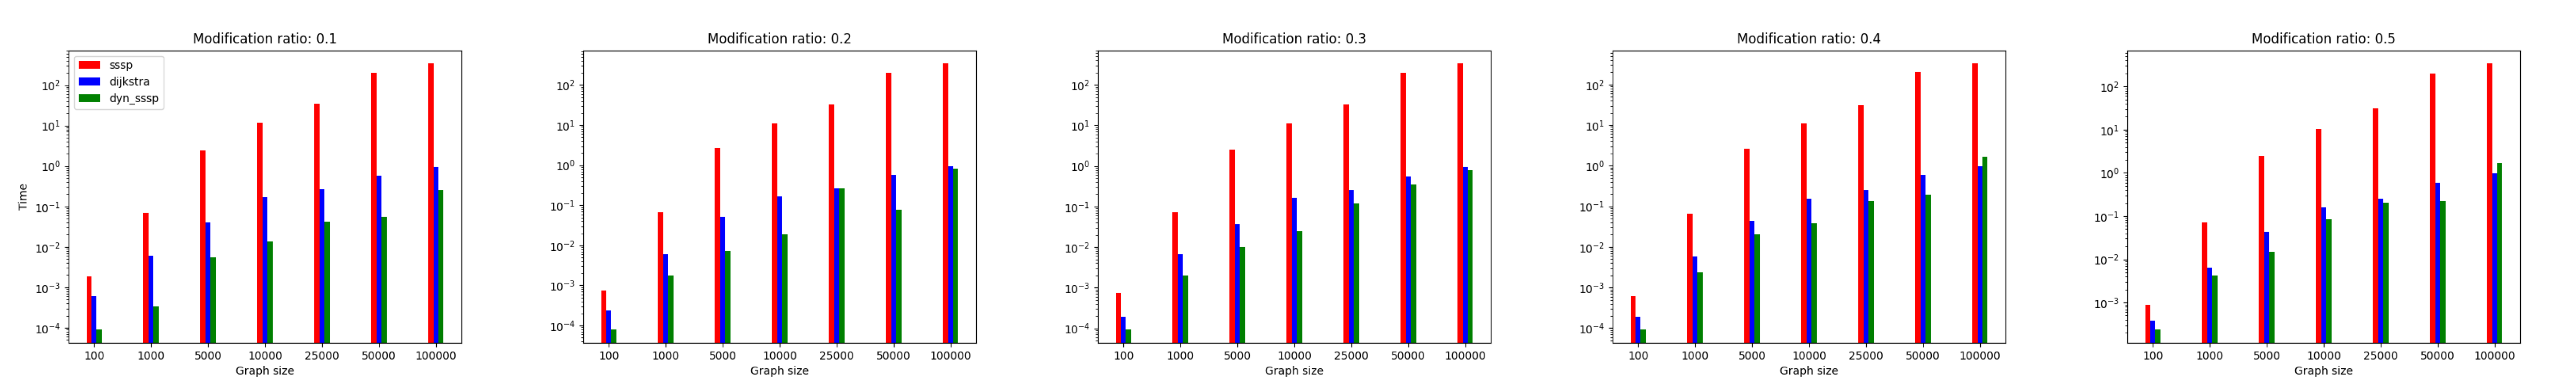

In [12]:
import imageio as iio

for t in ['inc', 'dec', 'full']:
    fig, axs = plt.subplots(
                ncols=len(changed_edges_num),
                figsize=(len(changed_edges_num) * 10, len(changed_edges_num) * 5),
            )
    plt_images = []

    for i in changed_edges_num:
        img = iio.v2.imread(f"{t}_{i}.png")
        plt_images.append(img)

    for ax, plot_image in zip(axs, plt_images):
                ax.imshow(plot_image)
                ax.axis("off")

    fig.tight_layout()


Представлены результаты эксперимента. Сверху вниз инкрементальных вариант, декрементальных и полный

## Выводы
1) Статический алгоритм Беллмана-Форда на основе матричных операций работает сильно медленнее при всех изменяемых параметрах эксперимента (размер графа, доля изменившихся ребер, тип обновления). Также можно заметить, что на всех графиках время работы алгоритма примерно одинаковое, оно меняется только при увеличении числа вершин в графе.
2) При малой доле обновленных ребер динамическая версия работает быстрее статической в десятки раз. Когда доля изменившихся ребер растет, алгоритмы примерно сравниваются по скорости.
3) При инкрементальном варианте разница в скорости работы статического и динамического алгоритмов больше, чем при декрементальном и полном.